In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "1012",
                             database = "ecommerce")
cur = db.cursor()                         

# 1:- List unique cities where customers are located.


In [47]:
query = """ select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Cities"])
df.head()

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2:-Count the number of orders placed in 2017.

In [16]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are",data [0][0]

('Total orders placed in 2017 are', 45101)

# 3:-Find the total sales per category.

In [24]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2)
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4:-Calculate the percentage of orders that were paid in installments.

In [30]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments",data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

# 5:-Count the number of customers from each state.

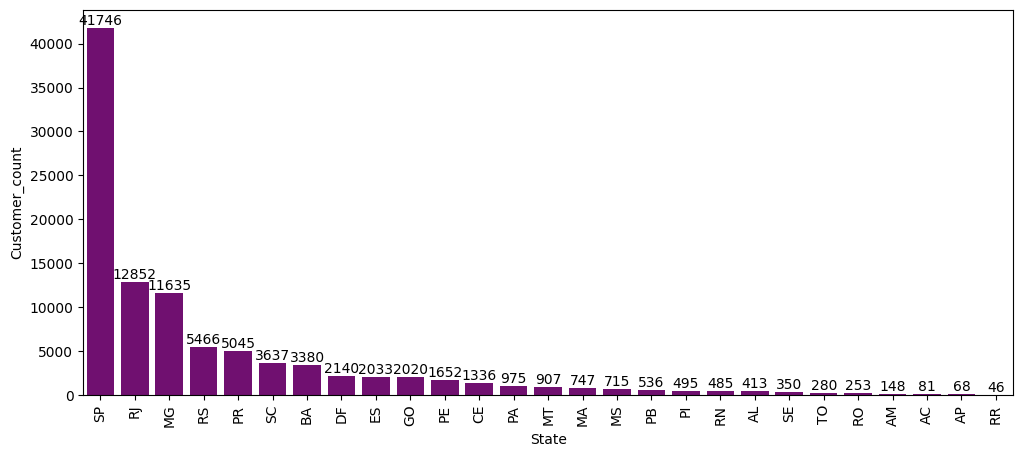

In [73]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State","Customer_count"])
df = df.sort_values(by = "Customer_count", ascending = False)
plt.figure(figsize = (12,5))
ax = sns.barplot(x = df["State"], y = df["Customer_count"], color = "purple")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.show()

# 6:-Calculate the number of orders per month in 2018.

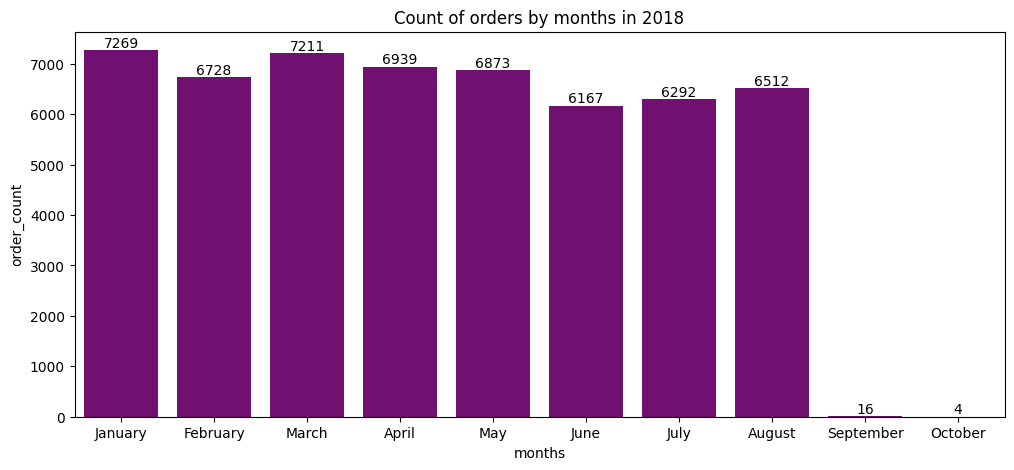

In [67]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) =2018
group by months"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January","February","March","April","May","June","July","August","September","October"]
plt.figure(figsize = (12,5))
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, color = "purple")
ax.bar_label(ax.containers[0])
plt.title("Count of orders by months in 2018")
plt.show()

# 7:-Find the average number of products per order, grouped by customer city.

In [82]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)
select customers.customer_city, round(avg(count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_order desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer city", "average order/order"])
df.head(10)

,customer city,average order/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 8:-Calculate the percentage of total revenue contributed by each product category.

In [86]:
query = """ select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Percentage distribution"])
df.head(5)

,Category,Percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# 9:-Identify the correlation between product price and the number of times a product has been purchased.

In [95]:
query = """select products.product_category, count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Order Count","Price"])
arr1 = df["Order Count"]
arr2 = df["Price"]
a = np.corrcoef([arr1,arr2])
print("The correlation between price and number of times a product has been purchased is", a[0][-1])

The correlation between price and number of times a product has been purchased is -0.10631514167157562


# 10:-Calculate the total revenue genrated by each seller, and rank them by revenue.

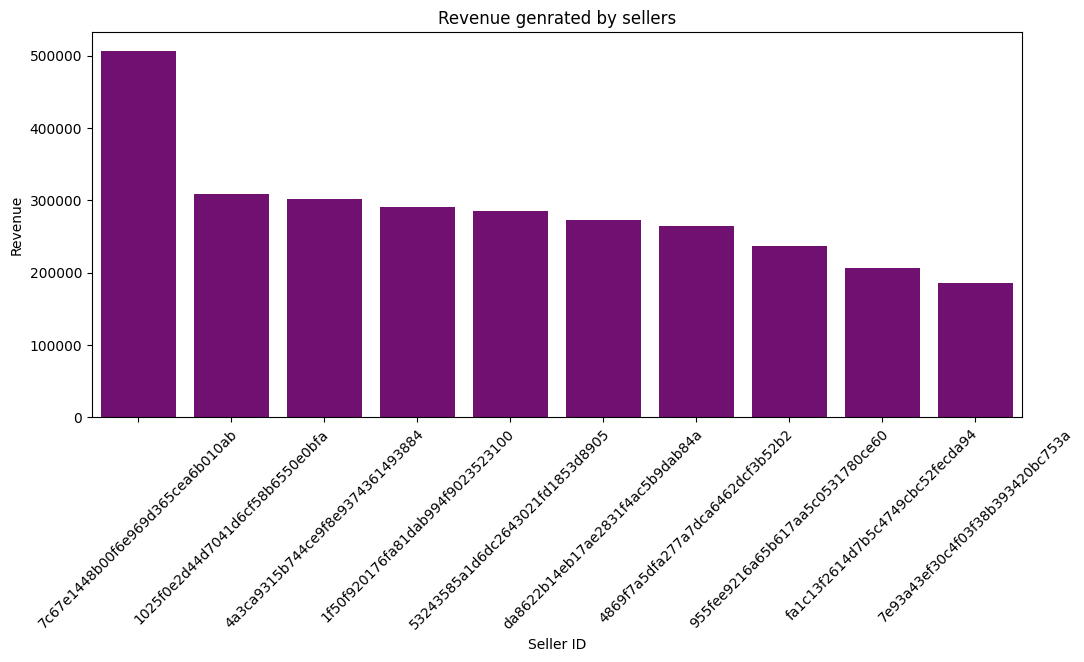

In [134]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, round(sum(payments.payment_value),2) revenue 
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller ID", "Revenue", "Rank"])
df = df.head(10)
plt.figure(figsize = (12,5))
sns.barplot(x = "Seller ID", y = "Revenue", data = df, color = "purple")
plt.title("Revenue genrated by sellers")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.show()

# 11:-calculate the moving average of order value from each customer over their order history.

In [120]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by orders.order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer ID", "Order Purchase", "Payment", "Moving Average"])
df.head(10)

,Customer ID,Order Purchase,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# 12:-Calculate the cumulative sales per month for each year.

In [121]:
query = """select years, months, sum(payment)
over(order by years, months) cumulative_sale from
(select year (orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Order Months", "Cumulative Sales"])
df.head(10)

,Years,Order Months,Cumulative Sales
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


# 13:- Calculate the year over growth rate of total sales.

In [126]:
query = """with a as(select year (orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years, ((payment-lag(payment,1) over(order by years))/ lag(payment,1) over(order by years))*100 from a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "YOY percent growth"])
df

,Years,YOY percent growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14:-Defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [127]:
query = """with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders on customers.customer_id = orders.customer_id
group by customers.customer_id),
b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order 
and orders.order_purchase_timestamp <  date_add(first_order, interval 6 month)
group by a.customer_id)
select 100 * (count(distinct a.customer_id) / count(distinct b.customer_id))
from a left join b on a.customer_id = b.customer_id"""
cur.execute(query)
data = cur.fetchall()
data
# their is no customer make another purchase.

[(None,)]

# 15:- Identify the top 3 customers who spent the most money in each year.

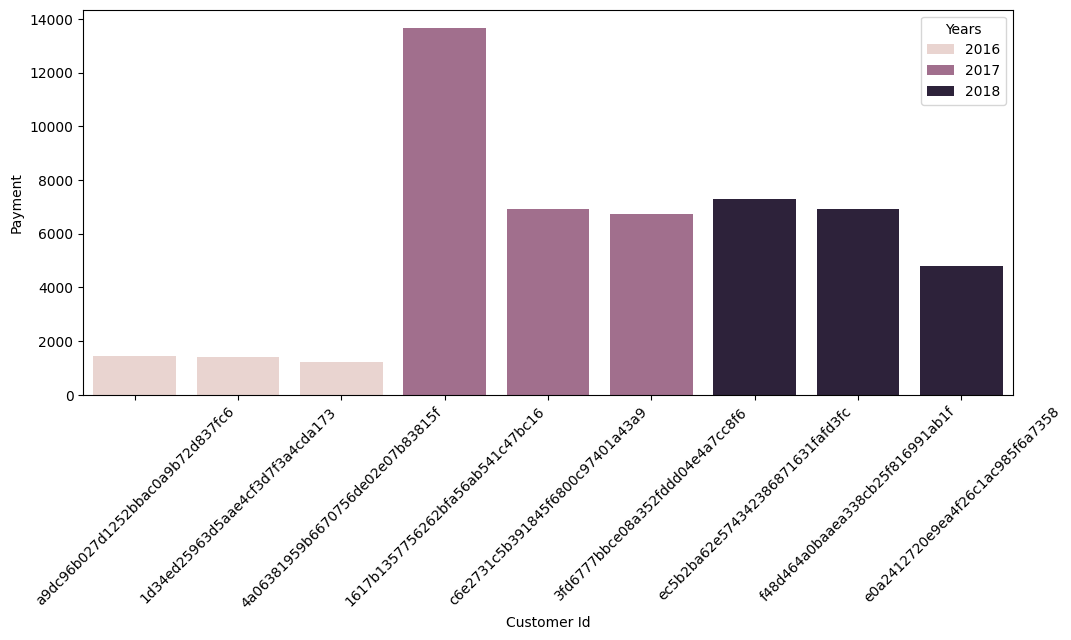

In [135]:
query = """select years, customer_id, payment, d_rank from
(select year(order_purchase_timestamp) years, orders.customer_id, sum(payments.payment_value) payment,
dense_rank() over (partition by year(order_purchase_timestamp)
order  by sum(payments.payment_value) desc) d_rank
from orders join payments on payments.order_id = orders.order_id
group by year(order_purchase_timestamp), orders.customer_id) as a
where d_rank <=3"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Customer Id","Payment","Rank"])
plt.figure(figsize = (12,5))
sns.barplot(x = "Customer Id", y = "Payment", data = df, hue = "Years")
plt.xticks(rotation = 45)
plt.show()